# Load data



In [0]:
#%cd ..
!rm -rf DD2424AL

In [1]:
# Load data from repo

!git clone https://github.com/Lingermania/DD2424AL
# Change the working directory to the repo root.
%cd DD2424AL

# Add the repo root to the Python path.
import sys, os
sys.path.append(os.getcwd())
sys.path.append('images') # Append folder paths

# Print contents
!ls

Cloning into 'DD2424AL'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 6228 (delta 19), reused 32 (delta 10), pack-reused 6187
Receiving objects: 100% (6228/6228), 1.34 GiB | 41.38 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Checking out files: 100% (6202/6202), done.
/content/DD2424AL
figs  grad_cam.py  images  loader.py  metadata.csv  README.md


# Transfer Learning

## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import loader
import grad_cam
import imutils
import cv2
from skimage.color import gray2rgb
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, InceptionResNetV2, ResNet50, Xception, NASNetLarge
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from keras.utils import to_categorical
from keras.utils import normalize
from sklearn.model_selection import train_test_split

In [0]:
# Test GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print('Tensorflow version', tf.__version__)

Found GPU at: /device:GPU:0
Tensorflow version 2.2.0


## Model

In [12]:
base = loader.ImageBase('metadata.csv', 'images')
#FIELD NAMES
base.meta.keys()
np.unique(base.meta['finding'])
#base.display_image_statistics(resolution = (100, 100))

array(['ARDS', 'COVID-19', 'COVID-19, ARDS', 'Chlamydophila', 'E.Coli',
       'Klebsiella', 'Legionella', 'NORMAL', 'No Finding',
       'PNEUMONIA, BACTERIA', 'PNEUMONIA, VIRUS', 'Pneumocystis', 'SARS',
       'Streptococcus'], dtype=object)

In [14]:
def crop_center(ims, imshape):
    '''
    assumes images to be squares and even numbered dimensions
    '''
    gs = ims.shape[1]
    margin = (gs - imshape[0])//2
    return ims[:, margin : gs - margin, margin : gs - margin]

#UNION -- List of fields to union, e.g., find all X-ray's
union = [{'modality' : ['X-ray']}]
#RESTRICTIONS -- List of restrictions, e.g., find all X-ray's of COVID-19 and SARS patients
restrictions = [{'finding' : ['COVID-19', 'COVID-19, ARDS']}]

#Third parameter is the output shape of imgs
imshape = (250,250)
getshape = (300, 300)
ims = base.get_category(union = union, restrictions = restrictions , shape = getshape)
ims = crop_center(ims, imshape)
#ims2 = base.get_category(union = union, restrictions = [{'finding' : ['PNEUMONIA, VIRUS', 'PNEUMONIA, BACTERIA', 'NORMAL']}], shape = imshape)
ims2 = base.get_category(union = union, restrictions = [{'finding' : ['PNEUMONIA, VIRUS', 'PNEUMONIA, BACTERIA', 'NORMAL']}], shape = getshape, size = 2000)
ims2 = crop_center(ims2, imshape)

print(ims.shape, ims2.shape)

100%|██████████| 2000/2000 [00:17<00:00, 113.61it/s]


(247, 250, 250) (2000, 250, 250)


In [48]:
#Display images
print("COVID-19")
#loader.ImageBase.montage(ims, figsize=(25,25))

# Set random seed
np.random.seed(seed=42)

np.random.shuffle(ims)
np.random.shuffle(ims2)

#data = np.concatenate((ims, ims2[:len(ims)]), axis=0)
data = np.concatenate((ims, ims2), axis=0)
#label = np.concatenate((np.zeros((len(ims))), np.ones((len(ims)))), axis = 0)
label = np.concatenate((np.zeros((len(ims))), np.ones((len(ims2)))), axis = 0)
#rest = ims2[len(ims):] # Unused images
#restlabel = np.ones((len(rest)))
index = np.arange(0, len(label), 1)
np.random.shuffle(index)
data = data[index]
label = label[index]
print("Number of covid samples = ", len(ims))
print("Total samples =", len(label))
print(data.shape, label.shape)

COVID-19
Number of covid samples =  247
Total samples = 2247
(2247, 250, 250) (2247,)


#Data Preproccesing

In [49]:
print("pre", data.shape)
X = gray2rgb(data)
#rest = gray2rgb(rest)
print("post", X.shape)
num_classes = 2
# Split into test,train & valid
x_train, x_test, y_train, y_test  = train_test_split(X,label, test_size=0.2) 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)

#Normalize
# x_train = normalize(x_train,axis=1)
# x_test =  normalize(x_test,axis=1)
# x_valid =  normalize(x_valid,axis=1)
# x_rest = normalize(rest, axis=1)
#x_rest = rest

#One hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
y_valid = to_categorical(y_valid, num_classes) 
#y_rest = to_categorical(restlabel, num_classes)

# # Add rest of unused images to test set
# x_test = np.concatenate((x_test, x_rest), axis=0)
# y_test = np.concatenate((y_test, y_rest), axis=0)

# # Try to free up some RAM
# del x_rest 
# del y_rest

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

pre (2247, 250, 250)
post (2247, 250, 250, 3)
(1347, 250, 250, 3) (1347, 2)
(450, 250, 250, 3) (450, 2)
(450, 250, 250, 3) (450, 2)


# Create model and transfer weights

### Data Augmentation

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=50, # Degree range for random rotations.
  width_shift_range=0.2, # How far you shift the image
  height_shift_range=0.2, # How far you shift the image
  shear_range=0.0,
  zoom_range=0.1, # How much you zoom the image
  fill_mode='constant' # Points outside the boundaries of the input are filled according to the given mode
)

covidargs = np.argwhere(np.argmax(y_train, axis=1)==0)

augmentedData = datagen.flow(
    #x_train,
    #y_train,
    x_train[covidargs.reshape(-1)],
    y_train[covidargs.reshape(-1)],
    batch_size=1,
    shuffle=False,
    seed=42,
)

In [51]:
x_aug = np.concatenate((x_train, augmentedData.x), axis = 0)
y_aug = np.concatenate((y_train, augmentedData.y), axis = 0)
print(x_train.shape, y_train.shape)
print(x_aug.shape, y_aug.shape)

(1347, 250, 250, 3) (1347, 2)
(1489, 250, 250, 3) (1489, 2)


In [53]:
keras.backend.clear_session()
#plt.imshow(x_train[0, :, :, :])
NUM_EPOCHS = 10
LEARNING_RATE = 0.00001
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(imshape[0], imshape[1], 3))
conv_base.trainable = False
#conv_base.summary()
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=['acc'])
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Last layer training

result=model.fit(x=x_aug, y=y_aug, validation_data = (x_valid, y_valid), verbose = 1, epochs= NUM_EPOCHS, callbacks=[callback])

# Fine-tune all layers

LEARNING_RATE = 0.00001
conv_base.trainable = True
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=['acc'])
result=model.fit(x=x_aug, y=y_aug, validation_data = (x_valid, y_valid), verbose = 1, epochs= NUM_EPOCHS, callbacks=[callback])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               14156032  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 68,493,282
Trainable params: 14,156,546
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/10
47/47 [==============================] - 33s 702ms/step - loss: 2.9264 - acc: 0.8086 - val_loss: 1.7723 - val_acc: 0.8844
Epoch 2/10
47/47 [==============================] - 29s 620ms/step - loss: 2.9253 - acc: 0.8093 - va

0.9711111111111111
450
Performance for each class
Class 1 accuracy: 0.8113207547169812
Class 2 accuracy: 0.9924433249370277
0.81 & 0.99 & 


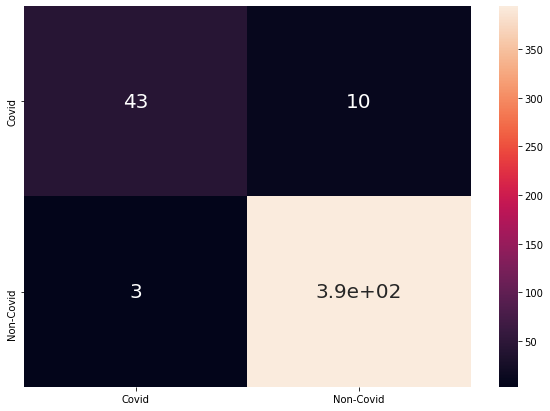

In [54]:
from sklearn.metrics import accuracy_score
preds = np.argmax(model.predict(x_test), axis = 1)

print(accuracy_score(preds, np.argmax(y_test, axis = 1)))

import seaborn as sn
import pandas as pd
K = 2
y_pred = preds

c_mat = np.zeros((K, K))

y_count = np.zeros((K,))
y_tot = np.zeros((K,))
yte = np.argmax(y_test, axis = 1)
print(len(yte))
for yt, yp in zip(yte, y_pred):
    yt, yp = yt, yp

    if yt == yp: y_count[yt] += 1
    y_tot[yt] +=1
    c_mat[yt, yp] += 1

c_mat = np.array(c_mat, dtype = np.int32)
print('Performance for each class')
s = ''
for k, (y, p) in enumerate(zip(y_count, y_tot)):
    print('Class {0} accuracy: {1}'.format(k+1, y/p))
    s += '{0} & '.format(round(y/p, 2))
print(s)
df_cm = pd.DataFrame(c_mat, index = ['Covid', 'Non-Covid'], columns = ['Covid', 'Non-Covid'], dtype = np.int32)

plt.figure(figsize= (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20})
plt.show()

# GRAD CAM

100%|██████████| 247/247 [00:09<00:00, 24.71it/s]


[0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0]


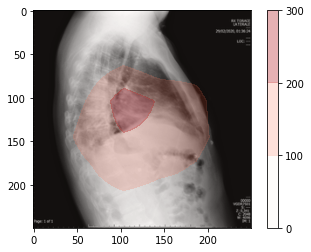

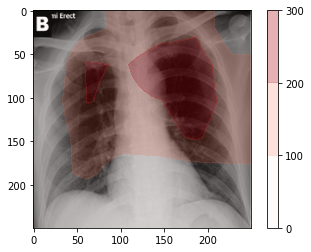

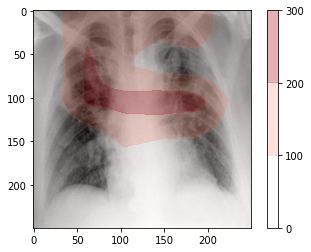

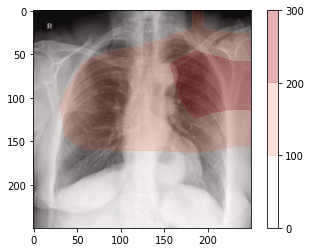

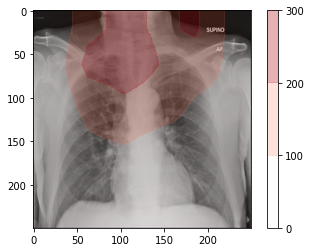

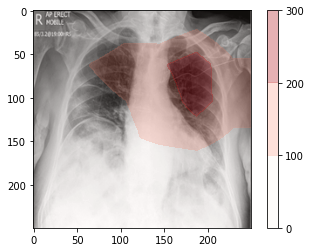

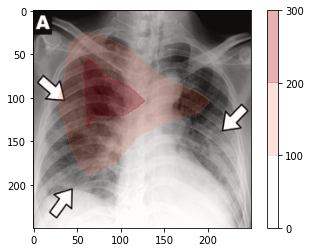

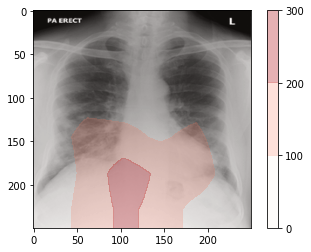

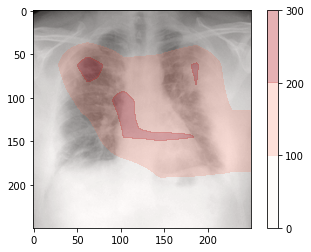

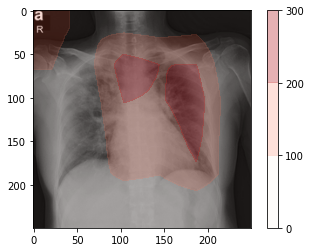

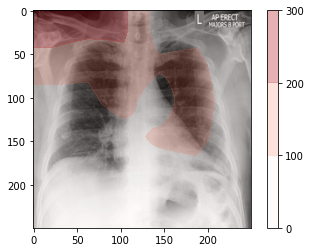

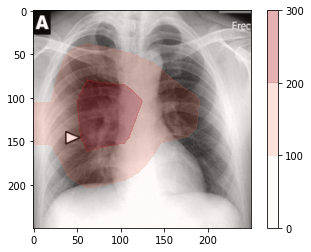

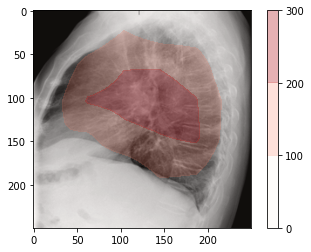

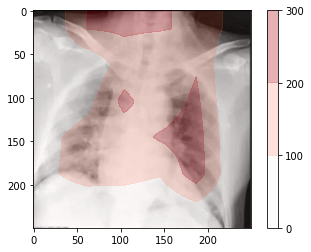

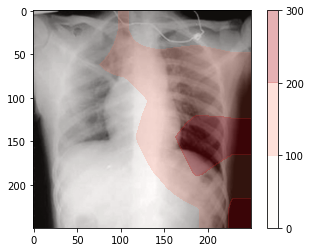

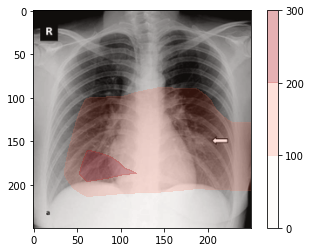

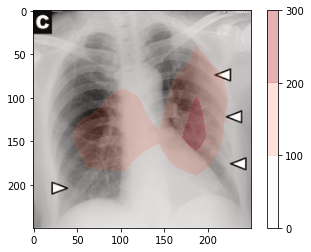

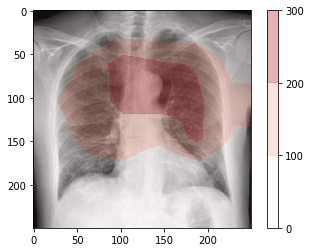

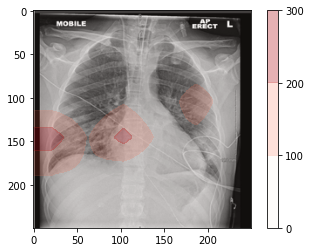

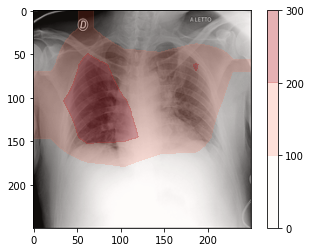

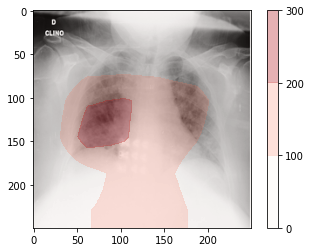

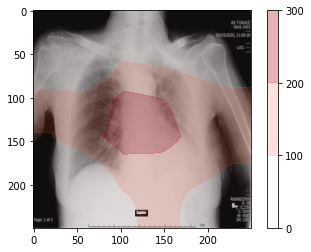

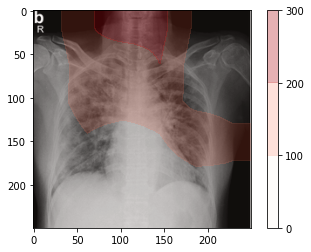

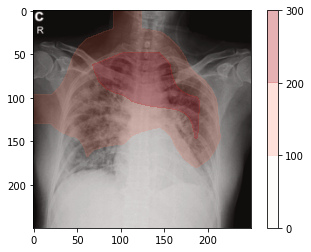

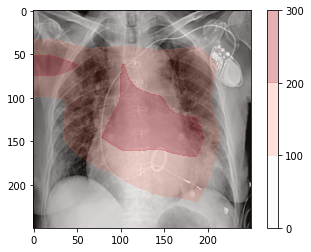

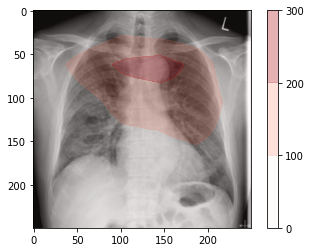

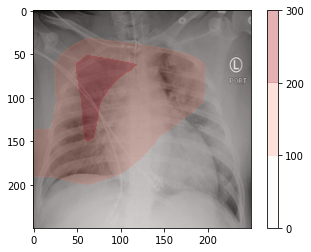

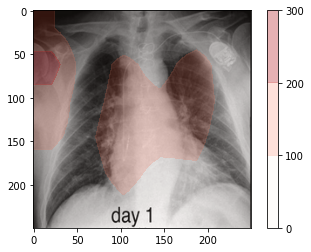

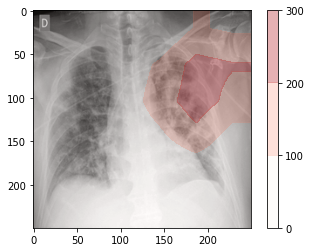

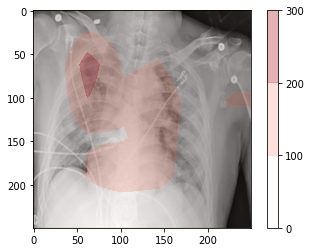

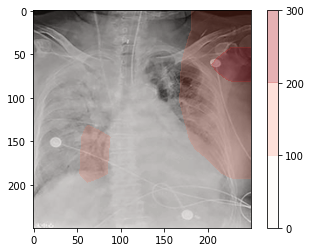

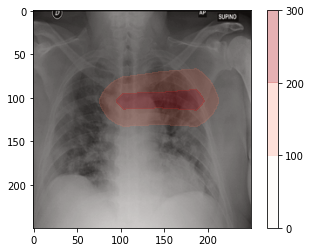

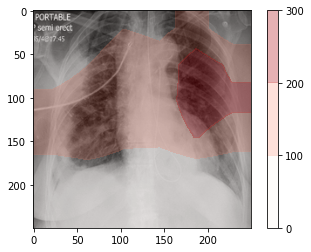

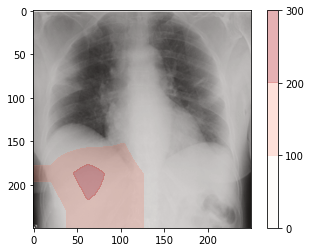

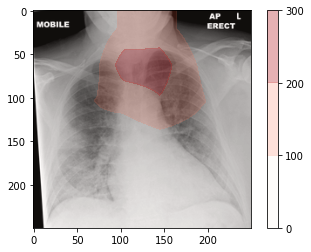

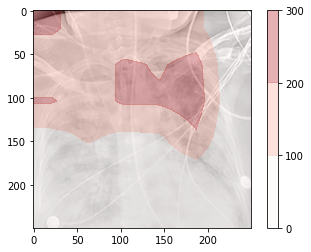

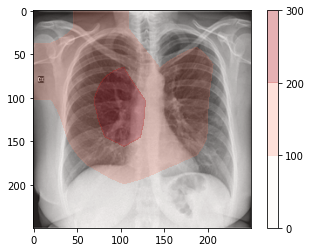

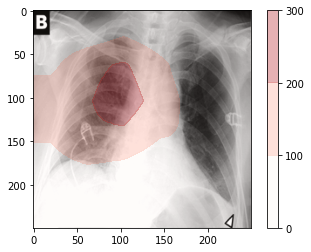

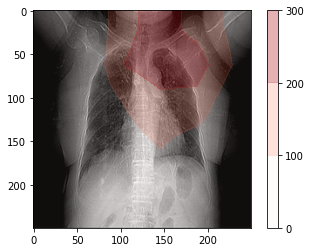

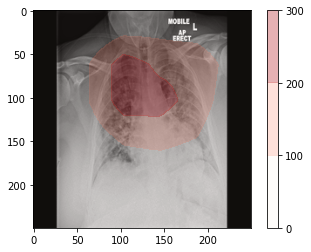

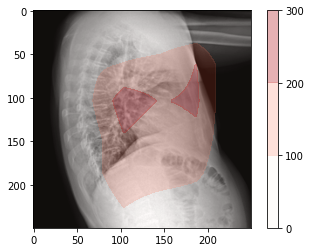

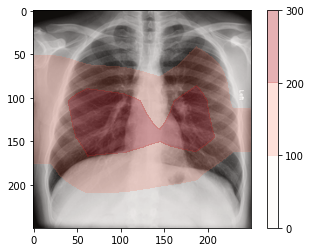

In [55]:
def transparent_cmap(cmap, N=255):
  "Copy colormap and set alpha values"

  mycmap = cmap
  mycmap._init()
  mycmap._lut[:,-1] = np.linspace(0, 0.4, N+4)
  return mycmap
#Sample k covid images

IMSIZE = (224, 224)
k = 50
imss = base.get_category(union = [{'modality' : ['X-ray']}], restrictions = [{'finding' : ['COVID-19', 'COVID-19, ARDS']}] , shape = imshape)
#ims = crop_center(ims, imshape)

rgbims = gray2rgb(imss)
#preds = np.argmax(model.predict(normalize(rgbims, axis = 1)), axis = 1)
preds = np.argmax(model.predict(rgbims), axis = 1)
print(preds)
import matplotlib.colors as mcolors
for i in range(k):
  if preds[i] == 0:
    cam = grad_cam.GradCAM(model, model.layers[0], preds[i], layerName=None)
    #image = np.expand_dims(normalize(rgbims[i, :, :, :], axis = 1), axis=0)
    image = np.expand_dims(rgbims[i, :, :, :], axis=0)
    orig = imss[i, :, :]

    heatmap = cam.compute_heatmap(image)
    
    
    #Plot image and overlay colormap
    w, h = heatmap.shape
    y, x = np.mgrid[0:h, 0:w]   
    mycmap = transparent_cmap(plt.cm.Reds)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(orig, cmap='gray')
    cb = ax.contourf(x, y, heatmap, 2, cmap=mycmap)
    plt.colorbar(cb)
    plt.show()


